# Diffusion Model for the Oxford Flowers 102 Dataset 

## Introduction

### Oxford Flowers 102 Dataset

https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

102 category dataset, consisting of 102 flower categories. The flowers chosen to be flower commonly
occuring in the United Kingdom. Each class consists of between 40 and 258 images. The images have 
large scale, pose and light variations. In addition, there are categories that have large variations
within the category and several very similar categories.

There are a total of 8349 images, a total download in ~330Mb.

More information in the TensorFlow Datasets page:

https://www.tensorflow.org/datasets/catalog/oxford_flowers102


The package [github.com/gomlx/gomlx/examples/oxfordflowers102](http://github.com/gomlx/gomlx/examples/oxfordflowers102)
provides a `train.Dataset` object that can be used to train models with the dataset. It also provides a simplified
mechanism to download and cache the dataset.

### Diffusion Model

This notebook is an example of a diffusion model, bsed on he Keras example in:

https://keras.io/examples/generative/ddim/



In [1]:
!*go mod edit --replace github.com/gomlx/gomlx=/home/janpf/Projects/gomlx

## Data Preprocessing

### Data directory and downloading the dataset

Bellow we call `DownloadAndParse`: it will only download if dataset files are not yet downloaded, otherwise it's a no-op.

This cell also defines some of the basics we will use later everywhere.

In [3]:
import (
    "flags"
    flowers "github.com/gomlx/gomlx/examples/oxfordflowers102"
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/types/shapes"
    "github.com/gomlx/gomlx/types/tensor"
    timage "github.com/gomlx/gomlx/types/tensor/image"
)


var (
    flagPlatform    = flag.String("platform", "", "Platform to use, if empty uses the default one.")
    flagDataDir = flag.String("data", "~/work/oxfordflowers102", "Directory to cache downloaded dataset and save checkpoints.")
    flagImageSize = flag.Int("size", 64, "Size of the images to use: since we'll cache them in the accelerator machine, it "+
                             "is limited by its memory. Largest value (the original image sizes) is 500.")
)

// DType used by the model.
var DType = shapes.F32 

var _ Graph  // Avoid error of `import . "gomlx/graph"` not used.

func AssertNoError(err error) {
    if err != nil {
        log.Fatalf("Failed: %+v", err)
    }
}

%%
AssertNoError(flowers.DownloadAndParse(*flagDataDir))

### Sample of Flowers

To do that we create a temporry dataset (with `NewDataset`) of size 256x256 pixels, and then show a sample of the flowers.

Later we will use a model that uses only 64x64 pixels.

Example 2273:barbeton daisy (40)(256x256 pixels),Example 3490:sweet william (29)(256x256 pixels),Example 927:frangipani (80)(256x256 pixels),Example 6321:common dandelion (49)(256x256 pixels),Example 1012:wallflower (45)(256x256 pixels),Example 54:passion flower (76)(256x256 pixels)
Example 3172:snapdragon (10)(256x256 pixels),Example 4109:artichoke (28)(256x256 pixels),Example 3562:azalea (71)(256x256 pixels),Example 5689:daffodil (41)(256x256 pixels),Example 8052:red ginger (23)(256x256 pixels),Example 3288:bird of paradise (7)(256x256 pixels)
Example 3362:bird of paradise (7)(256x256 pixels),Example 869:frangipani (80)(256x256 pixels),Example 929:frangipani (80)(256x256 pixels),Example 1786:hibiscus (82)(256x256 pixels),Example 3833:purple coneflower (16)(256x256 pixels),Example 894:frangipani (80)(256x256 pixels)
Example 1963:anthurium (79)(256x256 pixels),Example 7687:mallow (96)(256x256 pixels),Example 278:water lily (72)(256x256 pixels),Example 4282:peruvian lily (17)(256x256 pixels),Example 3303:bird of paradise (7)(256x256 pixels),Example 3792:cape flower (36)(256x256 pixels)

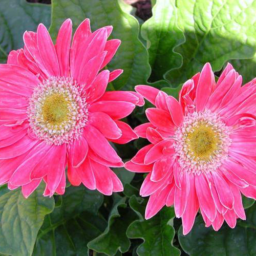
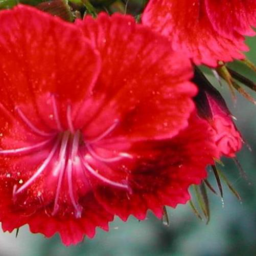
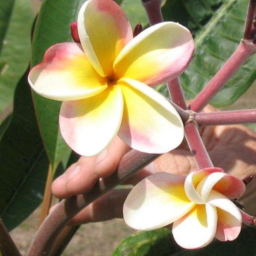
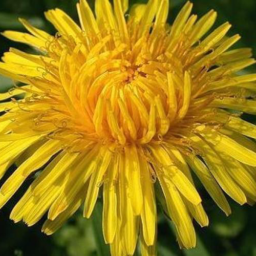
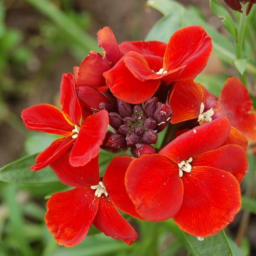
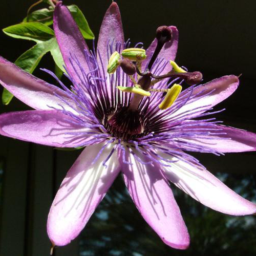
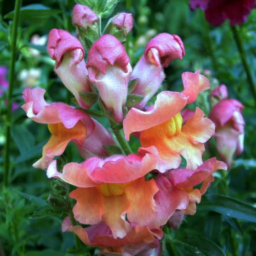
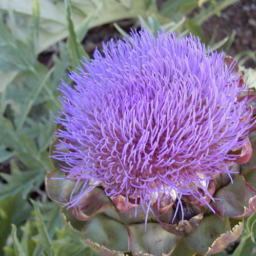
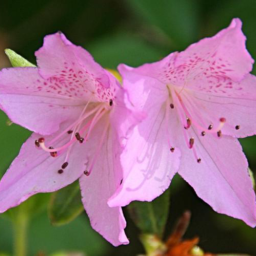
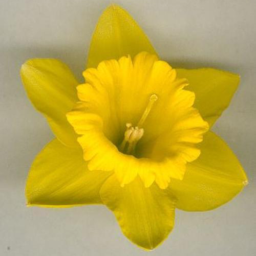
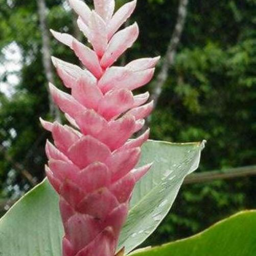
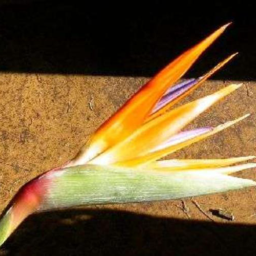
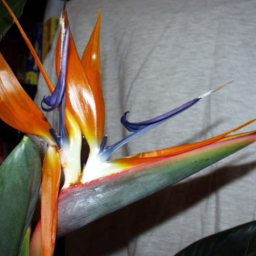
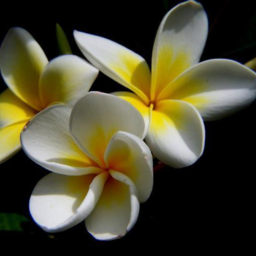
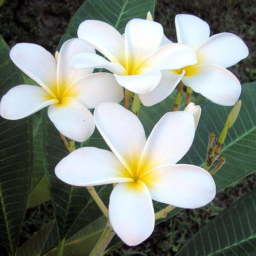
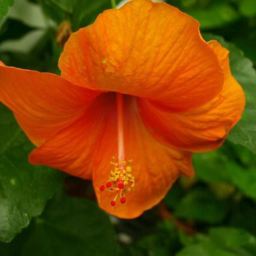
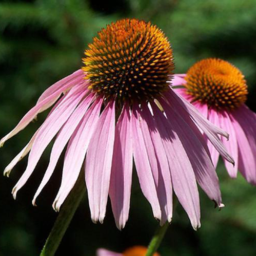
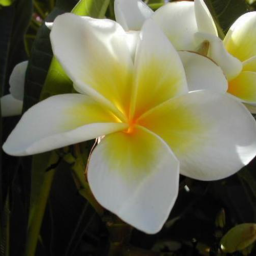
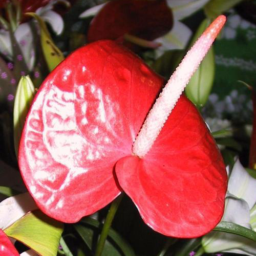
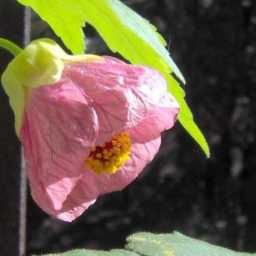
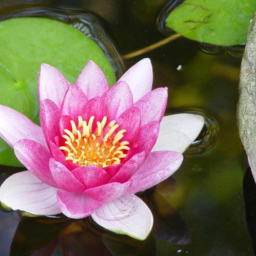
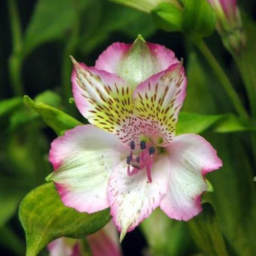
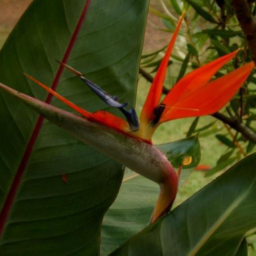
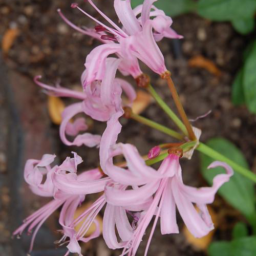

In [53]:

// sampleTable generates and outputs one html table of samples, sampling rows x cols from the images/labels provided.
func sampleTable(title string, ds train.Dataset, rows, cols int) {
    htmlRows := make([]string, 0, rows)
    for row := 0; row < rows; row++ {
        cells := make([]string, 0, cols)
        for col := 0; col < cols; col++ {
            cells = append(cells, sampleOneImage(ds))
        }
        htmlRows = append(htmlRows, fmt.Sprintf("<tr>\n\t<td>%s</td>\n</tr>", strings.Join(cells, "</td>\n\t<td>")))
    }
    htmlTable := fmt.Sprintf("<h3>%s</h3><table>%s</table>\n", title, strings.Join(htmlRows, ""))
    gonbui.DisplayHTML(htmlTable)
}

// sampleOneImage one image from tensor and returns an HTML rendered image with label
func sampleOneImage(ds train.Dataset) string {
    _, inputs, labels, err := ds.Yield()
    AssertNoError(err)
    imgTensor := inputs[0]
    img := timage.ToImage().Single(imgTensor)
    exampleNum := inputs[1].Local().Value().(int32)
    label := labels[0].Local().Value().(int32)
    labelStr := flowers.Names[label]
    
    imgSrc, err := gonbui.EmbedImageAsPNGSrc(img)
    AssertNoError(err)
    size := imgTensor.Shape().Dimensions[0]
    return fmt.Sprintf(`<figure style="padding:4px;text-align: center;"><img width="%d" height="%d" src="%s"><figcaption style="text-align: center;">Example %d:<br/><span>%s (%d)</span><br/>(%dx%d pixels)</figcaption></figure>`, 
                       size, size, imgSrc, exampleNum, labelStr, label, img.Bounds().Dx(), img.Bounds().Dy())
}

%% --size=256
AssertNoError(flowers.DownloadAndParse(*flagDataDir))
ds := flowers.NewDataset(shapes.U8, *flagImageSize)
ds.Shuffle()
sampleTable("Oxford 102 Flowers Dataset Sample", ds, 4, 6)
_ = BuildManager().MustDone()


### InMemory Dataset for Fast Access

We convert the flowers dataset to `InMemory`, and cache its contents for faster start-up time.

The first time it runs it will read and convert all images to the target size. But it then saves a cache of the generated content, so the second time it is faster.

In [82]:
import (
    "encoding/gob"
    "github.com/gomlx/gomlx/ml/data"
)

func CreateInMemoryDataset(manager *Manager) (mds *data.InMemoryDataset, err error) {
    return 
}

// Remove cached file to force regeneratrion.
!rm -f ${HOME}/work/oxfordflowers102/cached_images_*

%% --platform=Host
AssertNoError(flowers.DownloadAndParse(*flagDataDir))
manager := BuildManager().Platform(*flagPlatform).MustDone()
mds, err := flowers.InMemoryDataset(manager, *flagDataDir, *flagImageSize)
AssertNoError(err)
fmt.Printf("\tInMemoryDataset using %s of memory.\n", data.ByteCountIEC(mds.Memory()))


Creating InMemoryDataset with images cropped and scaled to 64x64...
	- 3.451505624s to process dataset.
	InMemoryDataset using 96.1 MiB of memory.


Example 2166:thorn apple (74)(64x64 pixels),Example 6226:oxeye daisy (48)(64x64 pixels),Example 3479:sweet william (29)(64x64 pixels),Example 2993:pink-yellow dahlia? (59)(64x64 pixels),Example 1237:rose (73)(64x64 pixels),Example 2036:anthurium (79)(64x64 pixels)

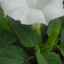
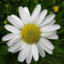
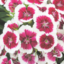
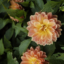
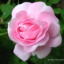
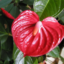

In [84]:
%%
AssertNoError(flowers.DownloadAndParse(*flagDataDir))
manager := BuildManager().Platform(*flagPlatform).MustDone()
mds, err := flowers.InMemoryDataset(manager, *flagDataDir, *flagImageSize)
AssertNoError(err)
mds.Shuffle()
sampleTable("Oxford 102 Flowers InMemoryDataset Sample", mds, 1, 6)

### Bechmarking the Dataset

To make sure we are performant, and that the dataset doesn't become a bottleneck during training, we do some benchmarking below:

In [85]:
import (
    "time"
    "github.com/gomlx/gomlx/ml/data"
    "github.com/gomlx/gomlx/ml/train"
)

func finalize(tensors []tensor.Tensor) {
    for _, t := range tensors {
        t.FinalizeAll()
    }
}

func BenchmarkDataset(ds train.Dataset) {
    // Warm up, run 100 ds.Yield().
    for ii := 0; ii < 100; ii++ {
        _, inputs, labels, err := ds.Yield()
        AssertNoError(err)
        finalize(inputs)
        finalize(labels)
    }
    
    // Start benchmark.
    start := time.Now()
    count := 0
    for count < 100 {
        _, inputs, labels, err := ds.Yield()
        if err == io.EOF {
            break
        }
        AssertNoError(err)
        finalize(inputs)
        finalize(labels)
        count++
    }
    elapsed := time.Since(start)
    fmt.Printf("\t%d batches read in %s\n", count, elapsed)
}

%%
AssertNoError(flowers.DownloadAndParse(*flagDataDir))

fmt.Println("Directly reading from disk:")
ds := flowers.NewDataset(shapes.F32, *flagImageSize)
BenchmarkDataset(ds)

fmt.Printf("\nParallelized (%d cpus) reading from disk:\n", runtime.NumCPU())
ds.Reset()
BenchmarkDataset(data.Parallel(ds))

fmt.Printf("\nInMemory dataset:\n")
manager := BuildManager().Platform(*flagPlatform).MustDone()
mds, err := flowers.InMemoryDataset(manager, *flagDataDir, *flagImageSize)
AssertNoError(err)
BenchmarkDataset(mds)

Directly reading from disk:
	100 batches read in 1.103548813s

Parallelized (24 cpus) reading from disk:
	100 batches read in 42.436494ms

InMemory dataset:
	100 batches read in 3.58882ms
